# Where do the water masses go in the Salish Sea?
Using the same water mass seperations as in CIOPS

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.interpolate as interp
from scipy.stats import pearsonr
import datetime as dt

import cmocean as cm
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from dateutil.relativedelta import relativedelta
import math
from matplotlib.gridspec import GridSpec
%matplotlib inline

plt.rcParams['font.size'] = 12

In [2]:
# round to 2 sig fig
def round_to_2(x):
    return np.round(x, -int(math.floor(math.log10(abs(x))))+1)

In [3]:
def get_data(mydata, starttime, endtime, time):
    salt = mydata.init_salt[(mydata.init_t >= starttime) & (mydata.init_t <= endtime)]
#     temp = mydata.init_t[(mydata.init_t >= starttime) & (mydata.init_t <= endtime)]
    init_depth = depthf(mydata.init_z[(mydata.init_t >= starttime) & (mydata.init_t <= endtime)]-1.)[0]
    depth = depthf(mydata.final_z[(mydata.init_t >= starttime) & (mydata.init_t <= endtime)]-1.)[0]
    section = mydata.final_section[(mydata.init_t >= starttime) & (mydata.init_t <= endtime)]
    trans = mydata.final_transp[(mydata.init_t >= starttime) & (mydata.init_t <= endtime)]/(time)
    init_trans = mydata.init_transp[(mydata.init_t >= starttime) & (mydata.init_t <= endtime)]/(time)
    lons = mydata.final_lon[(mydata.init_t >= starttime) & (mydata.init_t <= endtime)]
    return salt, depth, init_depth, section, trans, init_trans, lons

In [4]:
mymesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask201702.nc')
depthf = interp.interp1d(mymesh.z, mymesh.gdept_1d)

In [5]:
# section numbers
meander = 0
admiralty = 2
deception = 3
rosario = 4
sanjuan = 5
haro = 6
sec_name = ['meander', 'admiralty', 'deception', 'rosario', 'sanjuan', 'haro']

In [42]:
def draw_patches(fmask, ll, ul, u_lons, w_depths):
    topo = []
    for i in range(ll, ul):
        for j in range(39):
            if fmask[j, i] == 0:
                rect = Rectangle((u_lons[i], w_depths[j]), u_lons[i+1]-u_lons[i], w_depths[j+1]-w_depths[j])
                topo.append(rect)
    pc = PatchCollection(topo, facecolors='lightgray', edgecolors='lightgray')
    return(pc)

In [7]:
#lets make a fun lil matrix with all of the info we need about every channel to run the cross-section code
#in the format [section, jgridW, jgridE, figrid, maxdepth]
CSadmiralty = [2, 255, 267, 204, 300]
CSrosario = [4, 286, 307, 266, 300]
CSsanjuan = [5, 264, 266, 280, 300]
CSharo = [6, 218, 242, 304, 300]
CSjdf = [0, 18, 63, 377, 300]

#in the format [section, jgridS, jgridN, figrid, maxdepth]
CSdecep = [3, 246, 247, 309, 300]

In [43]:
def FluxCS(lonW, lonE, figrid, maxdepth, ax, lons, depths, transports, high, salfile, distlabel, title):
    igrid = figrid-1
    fmask = mymesh.fmask[0, :, igrid]
    tmask = mymesh.tmask[0]
    nav_lon = mymesh.nav_lon[igrid]
    
    f_lons = mymesh.glamf[0, igrid]
    u_lons = mymesh.glamv[0, igrid]
    w_depths = mymesh.gdepw_1d
    gridding=1
    
    
    m2lon = ((u_lons[lonE]-u_lons[lonW])/(mymesh.e2f[0, igrid, lonW:lonE].sum())).values
    f_dist = f_lons/m2lon
    
    dist = lons/m2lon
    vmax = high/np.sum(transports)/m2lon
    
    cmap = cm.cm.speed
    cmap.set_under('white')
    vmin = 0.0000000001
    
    H, xedges, yedges, im = ax.hist2d(lons, depths, bins=[np.array(f_lons[lonW-1:lonE:gridding]), w_depths[0]],weights= transports, cmap=cmap, vmin=vmin, vmax=vmax, density= True)
    
#     H = np.where(H>0, H, H*np.nan)

    cb1 = fig.colorbar(im, ax=ax)
    cb1.set_ticks([0, vmax])
    cb1.set_ticklabels([0, high])
    cb1.set_label('m s$^{-1}$', labelpad=-20, fontsize=14)
    
    xs, ys = np.meshgrid(np.array(f_lons[lonW-1:lonE+1]), np.array(w_depths[0]))
    salinity = 0.5*(np.ma.array(salfile.vosaline[0, :, igrid, lonW-1:lonE+1],
            mask=1-tmask[:, igrid, lonW-1:lonE+1]) +
            np.ma.array(salfile.vosaline[0, :, igrid+1, lonW-1:lonE+1],
            mask=1-tmask[:, igrid+1, lonW-1:lonE+1]))
    CS = ax.contour(xs, ys, salinity,  np.arange(29,35, 1), colors='b', zorder = 2)#, label= 'Mean salinity [$g \, kg^{-1}$]')
    ax.clabel(CS, inline=1, fontsize=12, fmt='%1.0f')
    
    if distlabel == True:
        distance = abs(round_to_2((f_dist[lonW-1]-f_dist[lonE+1]).values/1000))
        ax.set_xlabel("Cross-section width = "+str(distance)[:-2]+" km", fontsize=14)
    
    pc = draw_patches(fmask, lonW-2, lonE, np.array(u_lons), np.array(w_depths[0]))
    ax.add_collection(pc)

    ax.invert_yaxis()
    ax.set_xticks([u_lons[lonW+1], u_lons[lonE-1]])
    ax.set_ylabel('Depth [m]', fontsize=14)
    ax.set_xticklabels(np.round([u_lons[lonW+1], u_lons[lonE-1]],2))
    ax.set_xlim((u_lons[lonW-2], u_lons[lonE]))
    ax.set_ylim((maxdepth, 0))
    ax.set_title(str(title), fontsize=16)
    mydata.close()

In [10]:
# def SusanFluxCS(js, je, figrid, maxdepth, ax, lons, depths, trans, high):
#     igrid = figrid-1
#     f_lons = mymesh.glamf[0, igrid]
#     u_lons = mymesh.glamv[0, igrid] 
#     fmask = mymesh.fmask[0, :, igrid]
#     w_depths = mymesh.gdepw_1d
    
#     m2lon = ((u_lons[je]-u_lons[js])/(mymesh.e2f[0, igrid, js:je].sum())).values
    
#     cmap = cm.cm.speed
#     cmap.set_bad('white')
    
#     gridding = 1
# #     high = 0.2
#     vmax = high/trans.sum()
# #     fig, ax = plt.subplots(1, 1, figsize=(10, 10))
#     c, xedge, yedge, im = ax.hist2d(lons/m2lon, 
#                                 depths,
#                                 weights=trans,
#                                 bins=[np.array(f_lons[js:je:gridding])/m2lon, w_depths[0]],
#                                 cmap=cmap, 
#                                 density=True, vmax=vmax)
    
#     cb1 = fig.colorbar(im, ax=ax)
#     cb1.set_ticks([0, vmax])
#     cb1.set_ticklabels([0, high]) 
#     cb1.set_label('m s$^{-1}$', labelpad=-20, fontsize=14)


#     pc = Susan_draw_patches(fmask, js, je, np.array(u_lons)/m2lon, np.array(w_depths[0]))
#     ax.add_collection(pc);
#     ax.invert_yaxis();
#     ax.set_title(section_name);
#     ax.set_ylim((maxdepth, 0))
#     ax.set_xlim((u_lons[js-2], u_lons[je]))


In [9]:
path = "/results/SalishSea/month-avg.201905/"
salS17 = xr.open_dataset(path+"SalishSea_1m_201708_201708_grid_T.nc")
salW17 = xr.open_dataset(path+"SalishSea_1m_201801_201801_grid_T.nc")
salW16 = xr.open_dataset(path+"SalishSea_1m_201701_201701_grid_T.nc")

## summer 2017

In [47]:
yearjumps = [0,1,-2,1,0,1,0,1,1,0,1,0]
str_mo = ['jan', 'feb', 'mar', 'apr','may', 'jun', 'jul', 'aug', 'sep','oct', 'nov', 'dec']
sum_start = 1+(5*720+(sum(yearjumps[:5+1]*24)))
sum_end = 720+(8*720+(sum(yearjumps[:8+1]*24)))

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_1hr/forward_01jan17/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
salt, depth, init_depth, section, trans, init_trans, lons = get_data(mydata, sum_start, sum_end, sum_end-sum_start+1)

In [48]:
import time

In [49]:
time.ctime()

'Sat Dec 31 12:09:25 2022'

In [50]:
d = {'salt': salt, 'depth':depth, 'init_depth':init_depth, 'section':section, 'transport':trans, 'init_transport':init_trans, 'lon':lons}
dfS = pd.DataFrame(data=d)

In [51]:
time.ctime()

'Sat Dec 31 12:12:56 2022'

In [52]:
upwelled = dfS[(dfS.init_depth <= 200) & (dfS.salt >= 32)]
cuc = dfS[(dfS.init_depth > 200) & (dfS.salt >= 32)]
columbia = dfS[(dfS.salt < 32)]

In [11]:
[np.sum(upwelled.transport)/np.sum(dfS.transport)*100,np.sum(cuc.transport)/np.sum(dfS.transport)*100,
np.sum(columbia.transport)/np.sum(dfS.transport)*100]

[82.48644651961337, 6.267863370364149, 11.245690110022469]

In [12]:
# lets see what sections these groups get into 
# first upwelled
print('advects back out = ' + str(sum(upwelled.transport[upwelled.section == meander])/np.sum(upwelled.transport)*100))
print('haro = ' + str(sum(upwelled.transport[upwelled.section == haro])/np.sum(upwelled.transport)*100))
print('sanjuan = ' + str(sum(upwelled.transport[upwelled.section == sanjuan])/np.sum(upwelled.transport)*100))
print('rosario = ' + str(sum(upwelled.transport[upwelled.section == rosario])/np.sum(upwelled.transport)*100))
print('admiralty = ' + str(sum(upwelled.transport[upwelled.section == admiralty])/np.sum(upwelled.transport)*100))
print('deception = ' + str(sum(upwelled.transport[upwelled.section == deception])/np.sum(upwelled.transport)*100))

advects back out = 78.86193130464324
haro = 15.036141234040171
sanjuan = 0.8025543181691127
rosario = 1.6676706078259846
admiralty = 3.61407399127876
deception = 0.017539038600961242


In [13]:
# and deep
print('advects back out = ' + str(sum(cuc.transport[cuc.section == meander])/np.sum(cuc.transport)*100))
print('haro = ' + str(sum(cuc.transport[cuc.section == haro])/np.sum(cuc.transport)*100))
print('sanjuan = ' + str(sum(cuc.transport[cuc.section == sanjuan])/np.sum(cuc.transport)*100))
print('rosario = ' + str(sum(cuc.transport[cuc.section == rosario])/np.sum(cuc.transport)*100))
print('admiralty = ' + str(sum(cuc.transport[cuc.section == admiralty])/np.sum(cuc.transport)*100))
print('deception = ' + str(sum(cuc.transport[cuc.section == deception])/np.sum(cuc.transport)*100))

advects back out = 88.46222790645251
haro = 8.610096977372251
sanjuan = 0.4545295871380527
rosario = 0.8177067747539721
admiralty = 1.6480737956203904
deception = 0.007364958662847872


In [14]:
# columbia 
print('advects back out = ' + str(sum(columbia.transport[columbia.section == meander])/np.sum(columbia.transport)*100))
print('haro = ' + str(sum(columbia.transport[columbia.section == haro])/np.sum(columbia.transport)*100))
print('sanjuan = ' + str(sum(columbia.transport[columbia.section == sanjuan])/np.sum(columbia.transport)*100))
print('rosario = ' + str(sum(columbia.transport[columbia.section == rosario])/np.sum(columbia.transport)*100))
print('admiralty = ' + str(sum(columbia.transport[columbia.section == admiralty])/np.sum(columbia.transport)*100))
print('deception = ' + str(sum(columbia.transport[columbia.section == deception])/np.sum(columbia.transport)*100))

advects back out = 99.92800893015723
haro = 0.043914367160181295
sanjuan = 0.0019204581578246885
rosario = 0.0067040129977496985
admiralty = 0.01945223152815096
deception = 0.0


In [53]:
time = 720*4
distlabel= False

In [54]:
time = sum_end-sum_start+1
time

2928

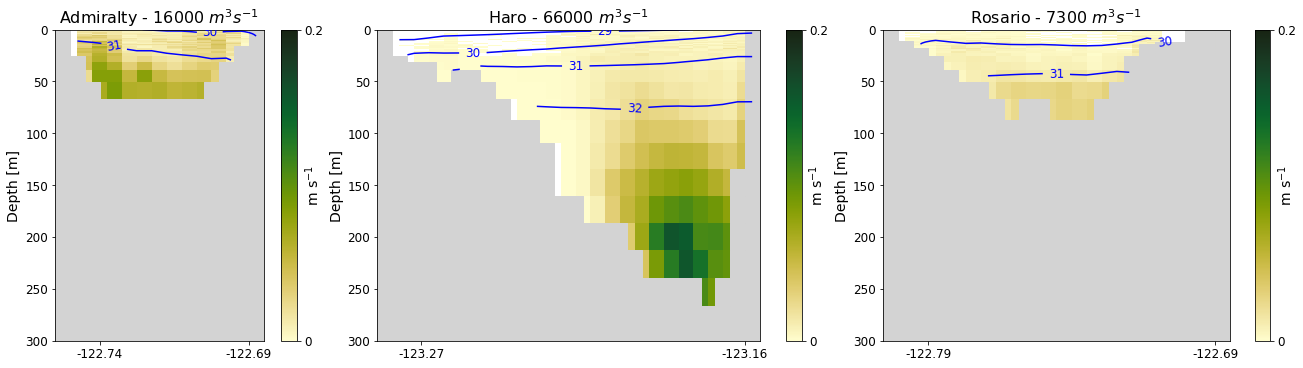

In [55]:
fig = plt.figure(constrained_layout=True, figsize=[18,5])
gs = GridSpec(1, 27, figure=fig)
ax0 = fig.add_subplot(gs[0, :6])
ax1 = fig.add_subplot(gs[0, 6:17])
ax2 = fig.add_subplot(gs[0, 17:27])

high = 0.2
title = "Admiralty - "+ str(round_to_2(np.sum(upwelled.transport[upwelled.section == admiralty])))[:-2] + " $m^3 s^{-1}$"
FluxCS(CSadmiralty[1], CSadmiralty[2], CSadmiralty[3], CSadmiralty[4], ax0, np.array(upwelled.lon[upwelled.section == admiralty]), np.array(upwelled.depth[upwelled.section == admiralty]), np.array(upwelled.transport[upwelled.section == admiralty]), high, salS17, distlabel, title)
title = "Haro - "+ str(round_to_2(np.sum(upwelled.transport[upwelled.section == haro])))[:-2] + " $m^3 s^{-1}$"
FluxCS(CSharo[1], CSharo[2], CSharo[3], CSharo[4], ax1, np.array(upwelled.lon[upwelled.section == haro]), np.array(upwelled.depth[upwelled.section == haro]), np.array(upwelled.transport[upwelled.section == haro]), high, salS17, distlabel, title)
title = "Rosario - "+ str(round_to_2(np.sum(upwelled.transport[upwelled.section == rosario])))[:-2] + " $m^3 s^{-1}$"
FluxCS(CSrosario[1], CSrosario[2], CSrosario[3], CSrosario[4], ax2, np.array(upwelled.lon[upwelled.section == rosario]), np.array(upwelled.depth[upwelled.section == rosario]), np.array(upwelled.transport[upwelled.section == rosario]), high, salS17, distlabel, title)

plt.savefig("./figures/InterChannelS17.png")

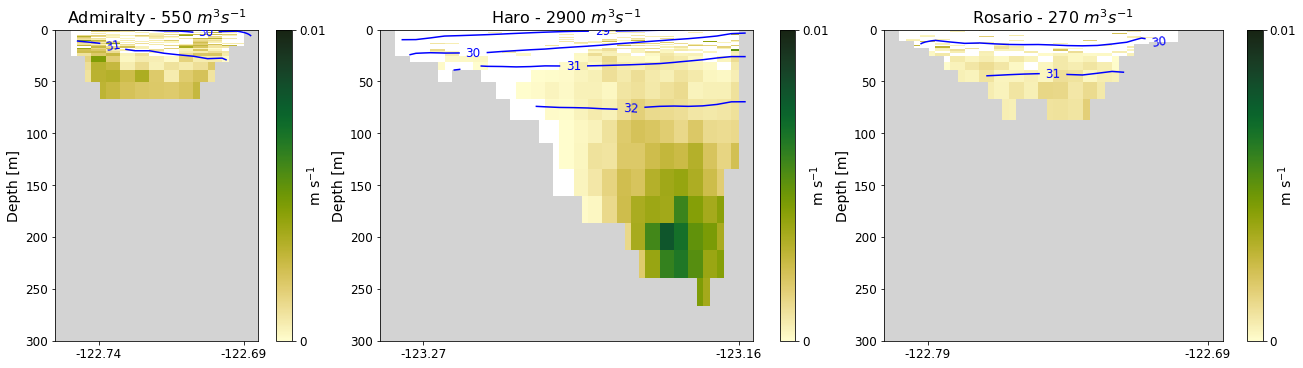

In [56]:
fig = plt.figure(constrained_layout=True, figsize=[18,5])
gs = GridSpec(1, 27, figure=fig)
ax0 = fig.add_subplot(gs[0, :6])
ax1 = fig.add_subplot(gs[0, 6:17])
ax2 = fig.add_subplot(gs[0, 17:27])

high = 0.01
title = "Admiralty - "+ str(round_to_2(np.sum(cuc.transport[cuc.section == admiralty])))[:-2] + " $m^3 s^{-1}$"
FluxCS(CSadmiralty[1], CSadmiralty[2], CSadmiralty[3], CSadmiralty[4], ax0, np.array(cuc.lon[cuc.section == admiralty]), np.array(cuc.depth[cuc.section == admiralty]), np.array(cuc.transport[cuc.section == admiralty]), high, salS17, distlabel, title)
title = "Haro - "+ str(round_to_2(np.sum(cuc.transport[cuc.section == haro])))[:-2] + " $m^3 s^{-1}$"
FluxCS(CSharo[1], CSharo[2], CSharo[3], CSharo[4], ax1, np.array(cuc.lon[cuc.section == haro]), np.array(cuc.depth[cuc.section == haro]), np.array(cuc.transport[cuc.section == haro]), high, salS17, distlabel, title)
title = "Rosario - "+ str(round_to_2(np.sum(cuc.transport[cuc.section == rosario])))[:-2] + " $m^3 s^{-1}$"
FluxCS(CSrosario[1], CSrosario[2], CSrosario[3], CSrosario[4], ax2, np.array(cuc.lon[cuc.section == rosario]), np.array(cuc.depth[cuc.section == rosario]), np.array(cuc.transport[cuc.section == rosario]), high, salS17, distlabel, title)

plt.savefig("./figures/DeepChannelS17.png")

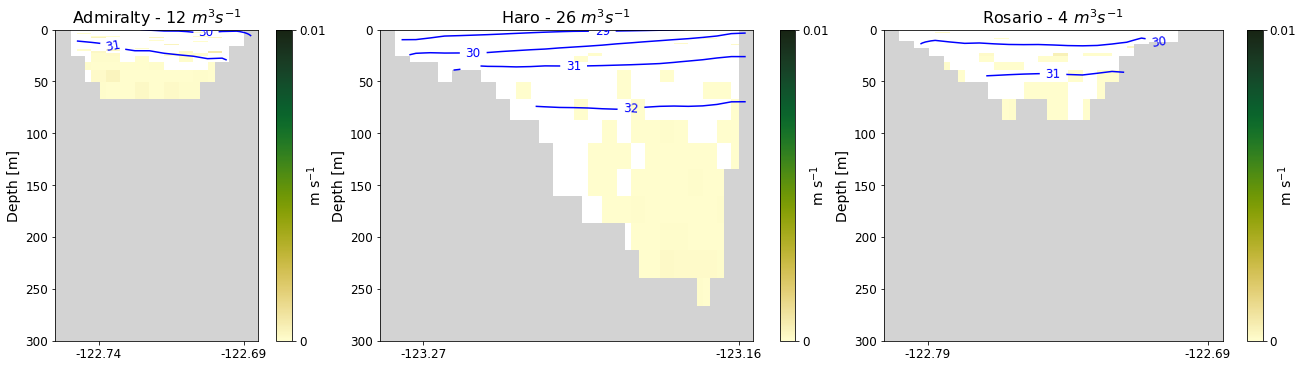

In [57]:
fig = plt.figure(constrained_layout=True, figsize=[18,5])
gs = GridSpec(1, 27, figure=fig)
ax0 = fig.add_subplot(gs[0, :6])
ax1 = fig.add_subplot(gs[0, 6:17])
ax2 = fig.add_subplot(gs[0, 17:27])

high = 0.01
title = "Admiralty - "+ str(round_to_2(np.sum(columbia.transport[columbia.section == admiralty])))[:-2] + " $m^3 s^{-1}$"
FluxCS(CSadmiralty[1], CSadmiralty[2], CSadmiralty[3], CSadmiralty[4], ax0, np.array(columbia.lon[columbia.section == admiralty]), np.array(columbia.depth[columbia.section == admiralty]), np.array(columbia.transport[columbia.section == admiralty]), high, salS17, distlabel, title)
title = "Haro - "+ str(round_to_2(np.sum(columbia.transport[columbia.section == haro])))[:-2] + " $m^3 s^{-1}$"
FluxCS(CSharo[1], CSharo[2], CSharo[3], CSharo[4], ax1, np.array(columbia.lon[columbia.section == haro]), np.array(columbia.depth[columbia.section == haro]), np.array(columbia.transport[columbia.section == haro]), high, salS17, distlabel, title)
title = "Rosario - "+ str(round_to_2(np.sum(columbia.transport[columbia.section == rosario])))[:-2] + " $m^3 s^{-1}$"
FluxCS(CSrosario[1], CSrosario[2], CSrosario[3], CSrosario[4], ax2, np.array(columbia.lon[columbia.section == rosario]), np.array(columbia.depth[columbia.section == rosario]), np.array(columbia.transport[columbia.section == rosario]), high, salS17, distlabel, title)

plt.savefig("./figures/PlumeChannelS17.png")

## Winter 2016/17

In [58]:
yearjumps = [0,1,-2,1,0,1,0,1,1,0,1,0]
str_mo = ['jan', 'feb', 'mar', 'apr','may', 'jun', 'jul', 'aug', 'sep','oct', 'nov', 'dec']
win_start1 = 1+(9*720+(sum(yearjumps[:9+1]*24)))
win_end1 = 720+(11*720+(sum(yearjumps[:11+1]*24)))

win_start2 = 1+(0*720+(sum(yearjumps[:0+1]*24)))
win_end2 = 720+(5*720+(sum(yearjumps[:5+1]*24)))

time = (win_end1-win_start1+1) + (win_end2-win_start2+1)

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_1hr/forward_01jan16/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
saltW, depthW, init_depthW, sectionW, transW, init_transW, lonsW = get_data(mydata, win_start1, win_end1, time)

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_1hr/forward_01jan17/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
saltS, depthS, init_depthS, sectionS, transS, init_transS, lonsS = get_data(mydata, win_start2, win_end2, time)

salt = np.append(saltW, saltS)
# temp = np.append(tempW, tempS)
depth = np.append(depthW, depthS)
init_depth = np.append(init_depthW, init_depthS)
section = np.append(sectionW, sectionS)
trans = np.append(transW, transS)
init_trans = np.append(init_transW, init_transS)
lons = np.append(lonsW, lonsS)

In [59]:
d = {'salt': salt, 'depth':depth, 'init_depth':init_depth, 'section':section, 'transport':trans, 'init_transport':init_trans, 'lon':lons}
dfW16 = pd.DataFrame(data=d)

In [60]:
upwelled = dfW16[(dfW16.init_depth <= 200) & (dfW16.salt >= 32)]
cuc = dfW16[(dfW16.init_depth > 200) & (dfW16.salt >= 32)]
columbia = dfW16[(dfW16.salt < 32)]

In [61]:
[np.sum(upwelled.transport)/np.sum(dfW16.transport)*100,np.sum(cuc.transport)/np.sum(dfW16.transport)*100,
np.sum(columbia.transport)/np.sum(dfW16.transport)*100]

[64.2684087916787, 6.177629978320642, 29.55396123000081]

In [23]:
# lets see what sections these groups get into 
# first upwelled
print('advects back out = ' + str(sum(upwelled.transport[upwelled.section == meander])/np.sum(upwelled.transport)*100))
print('haro = ' + str(sum(upwelled.transport[upwelled.section == haro])/np.sum(upwelled.transport)*100))
print('sanjuan = ' + str(sum(upwelled.transport[upwelled.section == sanjuan])/np.sum(upwelled.transport)*100))
print('rosario = ' + str(sum(upwelled.transport[upwelled.section == rosario])/np.sum(upwelled.transport)*100))
print('admiralty = ' + str(sum(upwelled.transport[upwelled.section == admiralty])/np.sum(upwelled.transport)*100))
print('deception = ' + str(sum(upwelled.transport[upwelled.section == deception])/np.sum(upwelled.transport)*100))

advects back out = 85.17386397539244
haro = 9.91421316235932
sanjuan = 0.5740827479382162
rosario = 1.053434394900841
admiralty = 3.1415864683580255
deception = 0.011236460294065059


In [24]:
# and deep
print('advects back out = ' + str(sum(cuc.transport[cuc.section == meander])/np.sum(cuc.transport)*100))
print('haro = ' + str(sum(cuc.transport[cuc.section == haro])/np.sum(cuc.transport)*100))
print('sanjuan = ' + str(sum(cuc.transport[cuc.section == sanjuan])/np.sum(cuc.transport)*100))
print('rosario = ' + str(sum(cuc.transport[cuc.section == rosario])/np.sum(cuc.transport)*100))
print('admiralty = ' + str(sum(cuc.transport[cuc.section == admiralty])/np.sum(cuc.transport)*100))
print('deception = ' + str(sum(cuc.transport[cuc.section == deception])/np.sum(cuc.transport)*100))

advects back out = 92.98476634950605
haro = 4.738547648240006
sanjuan = 0.2804731270793981
rosario = 0.4717373402471677
admiralty = 1.4006514306383469
deception = 0.0034210159098585617


In [25]:
# columbia 
print('advects back out = ' + str(sum(columbia.transport[columbia.section == meander])/np.sum(columbia.transport)*100))
print('haro = ' + str(sum(columbia.transport[columbia.section == haro])/np.sum(columbia.transport)*100))
print('sanjuan = ' + str(sum(columbia.transport[columbia.section == sanjuan])/np.sum(columbia.transport)*100))
print('rosario = ' + str(sum(columbia.transport[columbia.section == rosario])/np.sum(columbia.transport)*100))
print('admiralty = ' + str(sum(columbia.transport[columbia.section == admiralty])/np.sum(columbia.transport)*100))
print('deception = ' + str(sum(columbia.transport[columbia.section == deception])/np.sum(columbia.transport)*100))

advects back out = 98.0047934460504
haro = 1.0857124072430013
sanjuan = 0.09052175316362618
rosario = 0.14133444569202525
admiralty = 0.6645808983961088
deception = 0.0018448744611746753


In [62]:
distlabel=False

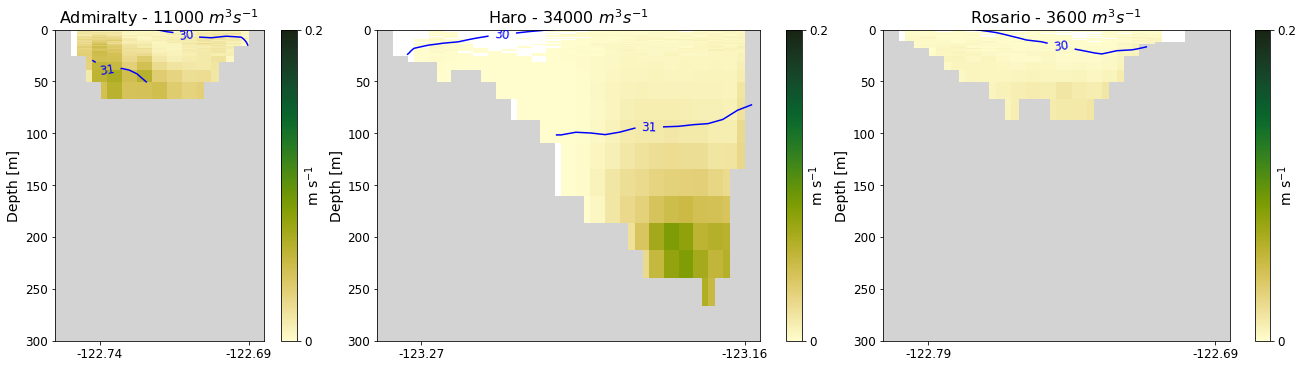

In [63]:
fig = plt.figure(constrained_layout=True, figsize=[18,5])
gs = GridSpec(1, 27, figure=fig)
ax0 = fig.add_subplot(gs[0, :6])
ax1 = fig.add_subplot(gs[0, 6:17])
ax2 = fig.add_subplot(gs[0, 17:27])

high = 0.2
title = "Admiralty - "+ str(round_to_2(np.sum(upwelled.transport[upwelled.section == admiralty])))[:-2] + " $m^3 s^{-1}$"
FluxCS(CSadmiralty[1], CSadmiralty[2], CSadmiralty[3], CSadmiralty[4], ax0, np.array(upwelled.lon[upwelled.section == admiralty]), np.array(upwelled.depth[upwelled.section == admiralty]), np.array(upwelled.transport[upwelled.section == admiralty]), high, salW16, distlabel, title)
title = "Haro - "+ str(round_to_2(np.sum(upwelled.transport[upwelled.section == haro])))[:-2] + " $m^3 s^{-1}$"
FluxCS(CSharo[1], CSharo[2], CSharo[3], CSharo[4], ax1, np.array(upwelled.lon[upwelled.section == haro]), np.array(upwelled.depth[upwelled.section == haro]), np.array(upwelled.transport[upwelled.section == haro]), high, salW16, distlabel, title)
title = "Rosario - "+ str(round_to_2(np.sum(upwelled.transport[upwelled.section == rosario])))[:-2] + " $m^3 s^{-1}$"
FluxCS(CSrosario[1], CSrosario[2], CSrosario[3], CSrosario[4], ax2, np.array(upwelled.lon[upwelled.section == rosario]), np.array(upwelled.depth[upwelled.section == rosario]), np.array(upwelled.transport[upwelled.section == rosario]), high, salW16, distlabel, title)

plt.savefig("./figures/InterChannelW16.png")

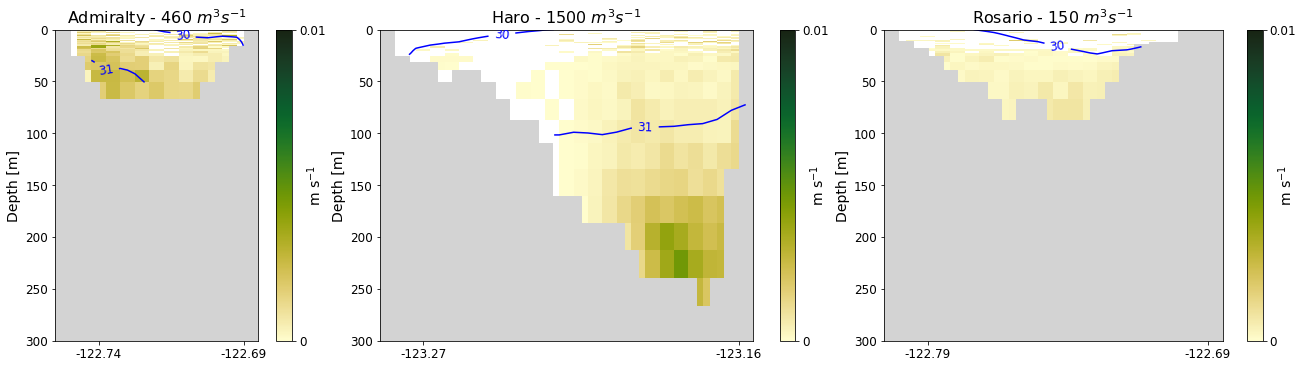

In [64]:
fig = plt.figure(constrained_layout=True, figsize=[18,5])
gs = GridSpec(1, 27, figure=fig)
ax0 = fig.add_subplot(gs[0, :6])
ax1 = fig.add_subplot(gs[0, 6:17])
ax2 = fig.add_subplot(gs[0, 17:27])

high = 0.01
title = "Admiralty - "+ str(round_to_2(np.sum(cuc.transport[cuc.section == admiralty])))[:-2] + " $m^3 s^{-1}$"
FluxCS(CSadmiralty[1], CSadmiralty[2], CSadmiralty[3], CSadmiralty[4], ax0, np.array(cuc.lon[cuc.section == admiralty]), np.array(cuc.depth[cuc.section == admiralty]), np.array(cuc.transport[cuc.section == admiralty]), high, salW16, distlabel, title)
title = "Haro - "+ str(round_to_2(np.sum(cuc.transport[cuc.section == haro])))[:-2] + " $m^3 s^{-1}$"
FluxCS(CSharo[1], CSharo[2], CSharo[3], CSharo[4], ax1, np.array(cuc.lon[cuc.section == haro]), np.array(cuc.depth[cuc.section == haro]), np.array(cuc.transport[cuc.section == haro]), high, salW16, distlabel, title)
title = "Rosario - "+ str(round_to_2(np.sum(cuc.transport[cuc.section == rosario])))[:-2] + " $m^3 s^{-1}$"
FluxCS(CSrosario[1], CSrosario[2], CSrosario[3], CSrosario[4], ax2, np.array(cuc.lon[cuc.section == rosario]), np.array(cuc.depth[cuc.section == rosario]), np.array(cuc.transport[cuc.section == rosario]), high, salW16, distlabel, title)

plt.savefig("./figures/DeepChannelW16.png")

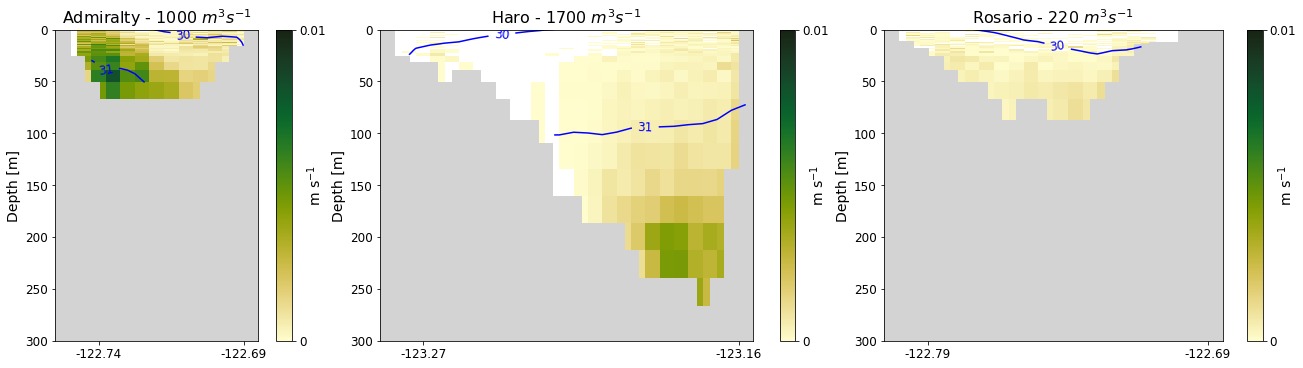

In [65]:
fig = plt.figure(constrained_layout=True, figsize=[18,5])
gs = GridSpec(1, 27, figure=fig)
ax0 = fig.add_subplot(gs[0, :6])
ax1 = fig.add_subplot(gs[0, 6:17])
ax2 = fig.add_subplot(gs[0, 17:27])

high = 0.01
title = "Admiralty - "+ str(round_to_2(np.sum(columbia.transport[columbia.section == admiralty])))[:-2] + " $m^3 s^{-1}$"
FluxCS(CSadmiralty[1], CSadmiralty[2], CSadmiralty[3], CSadmiralty[4], ax0, np.array(columbia.lon[columbia.section == admiralty]), np.array(columbia.depth[columbia.section == admiralty]), np.array(columbia.transport[columbia.section == admiralty]), high, salW16, distlabel, title)
title = "Haro - "+ str(round_to_2(np.sum(columbia.transport[columbia.section == haro])))[:-2] + " $m^3 s^{-1}$"
FluxCS(CSharo[1], CSharo[2], CSharo[3], CSharo[4], ax1, np.array(columbia.lon[columbia.section == haro]), np.array(columbia.depth[columbia.section == haro]), np.array(columbia.transport[columbia.section == haro]), high, salW16, distlabel, title)
title = "Rosario - "+ str(round_to_2(np.sum(columbia.transport[columbia.section == rosario])))[:-2] + " $m^3 s^{-1}$"
FluxCS(CSrosario[1], CSrosario[2], CSrosario[3], CSrosario[4], ax2, np.array(columbia.lon[columbia.section == rosario]), np.array(columbia.depth[columbia.section == rosario]), np.array(columbia.transport[columbia.section == rosario]), high, salW16, distlabel, title)

plt.savefig("./figures/PlumeChannelW16.png")

## Winter 2017/18

In [33]:
yearjumps = [0,1,-2,1,0,1,0,1,1,0,1,0]
str_mo = ['jan', 'feb', 'mar', 'apr','may', 'jun', 'jul', 'aug', 'sep','oct', 'nov', 'dec']
win_start = 1+(9*720+(sum(yearjumps[:9+1]*24)))
win_end = 720+(11*720+(sum(yearjumps[:11+1]*24)))

time = win_end-win_start+1+720*3

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_1hr/forward_01jan17/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
salt17, depth17, init_depth17, section17, trans17, init_trans17, lons17 = get_data(mydata, win_start, win_end, time)

start = 1
end = 720

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_1hr/forward_01jan18/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
salt_jan, depth_jan, init_depth_jan, section_jan, trans_jan, init_trans_jan, lons_jan = get_data(mydata, start, end, time)

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_1hr/forward_01feb18/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
salt_feb, depth_feb, init_depth_feb, section_feb, trans_feb, init_trans_feb, lons_feb = get_data(mydata, start, end, time)

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_1hr/forward_01mar18/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
salt_mar, depth_mar, init_depth_mar, section_mar, trans_mar, init_trans_mar, lons_mar = get_data(mydata, start, end, time)

salt = np.append(np.append(np.append(salt17, salt_jan), salt_feb), salt_mar)
# temp = np.append(np.append(np.append(temp17, temp_jan), temp_feb), temp_mar)
depth = np.append(np.append(np.append(depth17, depth_jan), depth_feb), depth_mar)
init_depth = np.append(np.append(np.append(init_depth17, init_depth_jan), init_depth_feb), init_depth_mar)
section = np.append(np.append(np.append(section17, section_jan), section_feb), section_mar)
trans = np.append(np.append(np.append(trans17, trans_jan), trans_feb), trans_mar)
init_trans = np.append(np.append(np.append(init_trans17, init_trans_jan), init_trans_feb), init_trans_mar)
lons = np.append(np.append(np.append(lons17, lons_jan), lons_feb), lons_mar)

In [34]:
d = {'salt': salt, 'depth':depth, 'init_depth':init_depth, 'section':section, 'transport':trans, 'init_transport':init_trans, 'lon':lons}
dfW17 = pd.DataFrame(data=d)

In [35]:
upwelled = dfW17[(dfW17.init_depth <= 200) & (dfW17.salt >= 32)]
cuc = dfW17[(dfW17.init_depth > 200) & (dfW17.salt >= 32)]
columbia = dfW17[(dfW17.salt < 32)]

In [47]:
[np.sum(upwelled.transport)/np.sum(dfW17.transport)*100,np.sum(cuc.transport)/np.sum(dfW17.transport)*100,
np.sum(columbia.transport)/np.sum(dfW17.transport)*100]

[65.9241674549636, 6.111738564545015, 27.964093980491416]

In [48]:
# lets see what sections these groups get into 
# first upwelled
print('advects back out = ' + str(sum(upwelled.transport[upwelled.section == meander])/np.sum(upwelled.transport)*100))
print('haro = ' + str(sum(upwelled.transport[upwelled.section == haro])/np.sum(upwelled.transport)*100))
print('sanjuan = ' + str(sum(upwelled.transport[upwelled.section == sanjuan])/np.sum(upwelled.transport)*100))
print('rosario = ' + str(sum(upwelled.transport[upwelled.section == rosario])/np.sum(upwelled.transport)*100))
print('admiralty = ' + str(sum(upwelled.transport[upwelled.section == admiralty])/np.sum(upwelled.transport)*100))
print('deception = ' + str(sum(upwelled.transport[upwelled.section == deception])/np.sum(upwelled.transport)*100))

advects back out = 85.97444964287644
haro = 8.690568919347369
sanjuan = 0.5386498966855549
rosario = 0.869467537250145
admiralty = 3.0125740880854663
deception = 0.009655686603563689


In [49]:
# and deep
print('advects back out = ' + str(sum(cuc.transport[cuc.section == meander])/np.sum(cuc.transport)*100))
print('haro = ' + str(sum(cuc.transport[cuc.section == haro])/np.sum(cuc.transport)*100))
print('sanjuan = ' + str(sum(cuc.transport[cuc.section == sanjuan])/np.sum(cuc.transport)*100))
print('rosario = ' + str(sum(cuc.transport[cuc.section == rosario])/np.sum(cuc.transport)*100))
print('admiralty = ' + str(sum(cuc.transport[cuc.section == admiralty])/np.sum(cuc.transport)*100))
print('deception = ' + str(sum(cuc.transport[cuc.section == deception])/np.sum(cuc.transport)*100))

advects back out = 92.52964159138327
haro = 4.624511124400911
sanjuan = 0.29942634018087494
rosario = 0.4781318927019483
admiralty = 1.4622744152245146
deception = 0.004883209810955023


In [50]:
# columbia 
print('advects back out = ' + str(sum(columbia.transport[columbia.section == meander])/np.sum(columbia.transport)*100))
print('haro = ' + str(sum(columbia.transport[columbia.section == haro])/np.sum(columbia.transport)*100))
print('sanjuan = ' + str(sum(columbia.transport[columbia.section == sanjuan])/np.sum(columbia.transport)*100))
print('rosario = ' + str(sum(columbia.transport[columbia.section == rosario])/np.sum(columbia.transport)*100))
print('admiralty = ' + str(sum(columbia.transport[columbia.section == admiralty])/np.sum(columbia.transport)*100))
print('deception = ' + str(sum(columbia.transport[columbia.section == deception])/np.sum(columbia.transport)*100))

advects back out = 97.28228697517741
haro = 1.2619076470602044
sanjuan = 0.0958267983786717
rosario = 0.17352586684365526
admiralty = 1.0402786635651784
deception = 0.0028308334876133616


In [36]:
distlabel = True

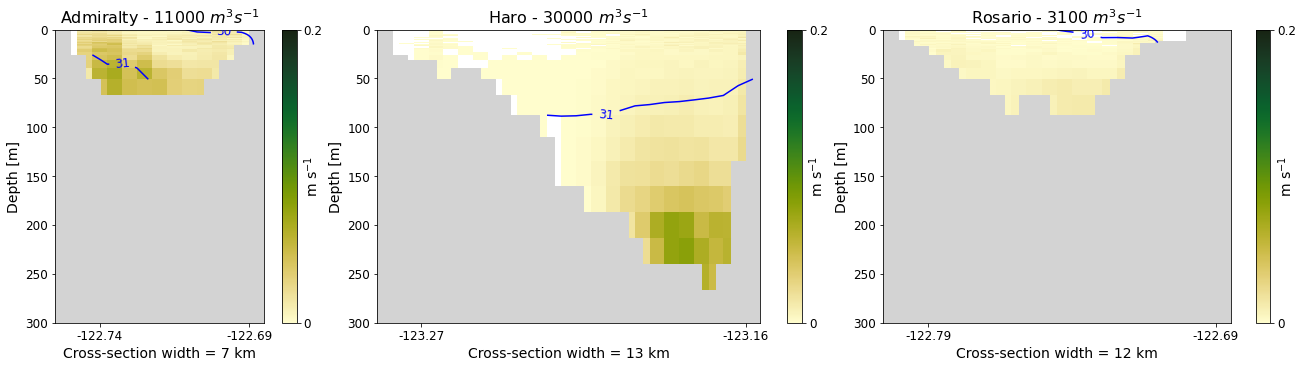

In [46]:
fig = plt.figure(constrained_layout=True, figsize=[18,5])
gs = GridSpec(1, 27, figure=fig)
ax0 = fig.add_subplot(gs[0, :6])
ax1 = fig.add_subplot(gs[0, 6:17])
ax2 = fig.add_subplot(gs[0, 17:27])

high = 0.2
title = "Admiralty - "+ str(round_to_2(np.sum(upwelled.transport[upwelled.section == admiralty])))[:-2] + " $m^3 s^{-1}$"
FluxCS(CSadmiralty[1], CSadmiralty[2], CSadmiralty[3], CSadmiralty[4], ax0, np.array(upwelled.lon[upwelled.section == admiralty]), np.array(upwelled.depth[upwelled.section == admiralty]), np.array(upwelled.transport[upwelled.section == admiralty]), high, salW17, distlabel, title)
title = "Haro - "+ str(round_to_2(np.sum(upwelled.transport[upwelled.section == haro])))[:-2] + " $m^3 s^{-1}$"
FluxCS(CSharo[1], CSharo[2], CSharo[3], CSharo[4], ax1, np.array(upwelled.lon[upwelled.section == haro]), np.array(upwelled.depth[upwelled.section == haro]), np.array(upwelled.transport[upwelled.section == haro]), high, salW17, distlabel, title)
title = "Rosario - "+ str(round_to_2(np.sum(upwelled.transport[upwelled.section == rosario])))[:-2] + " $m^3 s^{-1}$"
FluxCS(CSrosario[1], CSrosario[2], CSrosario[3], CSrosario[4], ax2, np.array(upwelled.lon[upwelled.section == rosario]), np.array(upwelled.depth[upwelled.section == rosario]), np.array(upwelled.transport[upwelled.section == rosario]), high, salW17, distlabel, title)

plt.savefig("./figures/InterChannelW17.png")

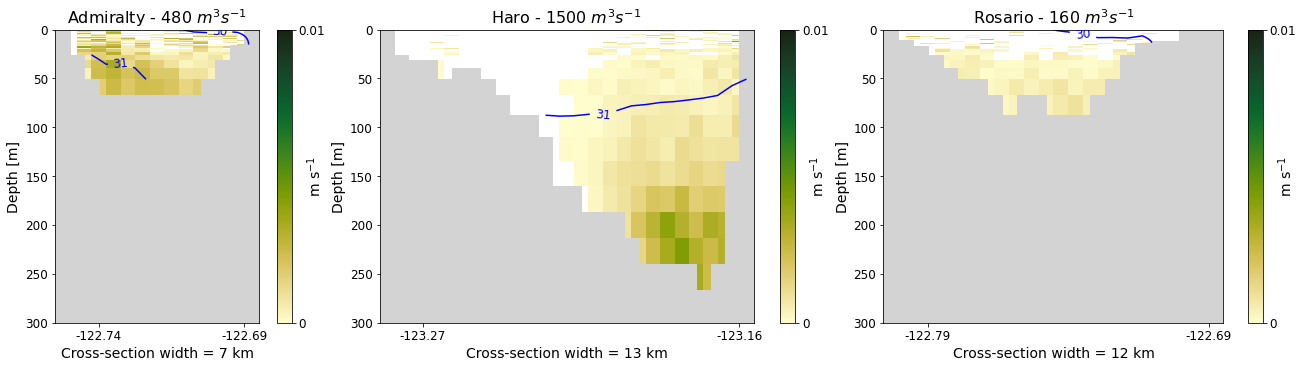

In [44]:
fig = plt.figure(constrained_layout=True, figsize=[18,5])
gs = GridSpec(1, 27, figure=fig)
ax0 = fig.add_subplot(gs[0, :6])
ax1 = fig.add_subplot(gs[0, 6:17])
ax2 = fig.add_subplot(gs[0, 17:27])

high = 0.01
title = "Admiralty - "+ str(round_to_2(np.sum(cuc.transport[cuc.section == admiralty])))[:-2] + " $m^3 s^{-1}$"
FluxCS(CSadmiralty[1], CSadmiralty[2], CSadmiralty[3], CSadmiralty[4], ax0, np.array(cuc.lon[cuc.section == admiralty]), np.array(cuc.depth[cuc.section == admiralty]), np.array(cuc.transport[cuc.section == admiralty]), high, salW17, distlabel, title)
title = "Haro - "+ str(round_to_2(np.sum(cuc.transport[cuc.section == haro])))[:-2] + " $m^3 s^{-1}$"
FluxCS(CSharo[1], CSharo[2], CSharo[3], CSharo[4], ax1, np.array(cuc.lon[cuc.section == haro]), np.array(cuc.depth[cuc.section == haro]), np.array(cuc.transport[cuc.section == haro]), high, salW17, distlabel, title)
title = "Rosario - "+ str(round_to_2(np.sum(cuc.transport[cuc.section == rosario])))[:-2] + " $m^3 s^{-1}$"
FluxCS(CSrosario[1], CSrosario[2], CSrosario[3], CSrosario[4], ax2, np.array(cuc.lon[cuc.section == rosario]), np.array(cuc.depth[cuc.section == rosario]), np.array(cuc.transport[cuc.section == rosario]), high, salW17, distlabel, title)

plt.savefig("./figures/DeepChannelW17.png")

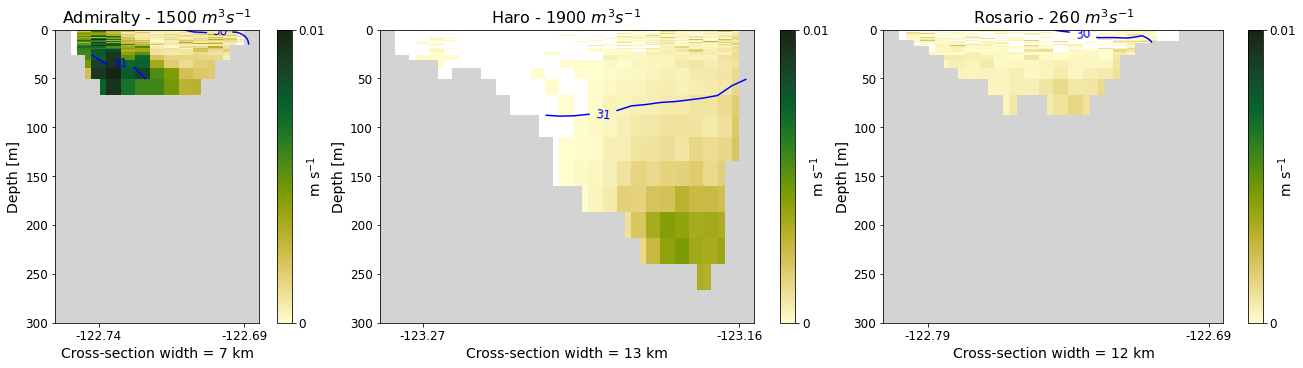

In [45]:
fig = plt.figure(constrained_layout=True, figsize=[18,5])
gs = GridSpec(1, 27, figure=fig)
ax0 = fig.add_subplot(gs[0, :6])
ax1 = fig.add_subplot(gs[0, 6:17])
ax2 = fig.add_subplot(gs[0, 17:27])

high = 0.01
title = "Admiralty - "+ str(round_to_2(np.sum(columbia.transport[columbia.section == admiralty])))[:-2] + " $m^3 s^{-1}$"
FluxCS(CSadmiralty[1], CSadmiralty[2], CSadmiralty[3], CSadmiralty[4], ax0, np.array(columbia.lon[columbia.section == admiralty]), np.array(columbia.depth[columbia.section == admiralty]), np.array(columbia.transport[columbia.section == admiralty]), high, salW17, distlabel, title)
title = "Haro - "+ str(round_to_2(np.sum(columbia.transport[columbia.section == haro])))[:-2] + " $m^3 s^{-1}$"
FluxCS(CSharo[1], CSharo[2], CSharo[3], CSharo[4], ax1, np.array(columbia.lon[columbia.section == haro]), np.array(columbia.depth[columbia.section == haro]), np.array(columbia.transport[columbia.section == haro]), high, salW17, distlabel, title)
title = "Rosario - "+ str(round_to_2(np.sum(columbia.transport[columbia.section == rosario])))[:-2] + " $m^3 s^{-1}$"
FluxCS(CSrosario[1], CSrosario[2], CSrosario[3], CSrosario[4], ax2, np.array(columbia.lon[columbia.section == rosario]), np.array(columbia.depth[columbia.section == rosario]), np.array(columbia.transport[columbia.section == rosario]), high, salW17, distlabel, title)

plt.savefig("./figures/PlumeChannelW17.png")

# plots of water masses to straits or meander?

In [7]:
starttime = 1
endtime = 720
yearjumps = [0,1,-2,1,0,1,0,1,1,0,1,0]

freshSOG = np.array([])
# freshOUT = np.array([])
freshPS = np.array([])
    
cucSOG = np.array([])
# cucOUT = np.array([])
cucPS = np.array([])
    
upSOG = np.array([])
# upOUT = np.array([])
upPS = np.array([])
# k = np.array([])
SoG = np.array([])
PS = np.array([])


#216 and 2017
year = [16,17]

for num in year:
    file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_1hr/forward_01jan'+str(num)+'/ariane_positions_quantitative.nc'
    mydata = xr.open_dataset(file)
    for i in range(12):
        start, end = starttime+(i*720+(sum(yearjumps[:i+1]*24))), endtime+(i*720+(sum(yearjumps[:i+1]*24)))
        
        XSOG = np.sum(mydata.final_transp[np.logical_or(np.logical_or((mydata.final_section==haro),(mydata.final_section==rosario)), (mydata.final_section==sanjuan))& (mydata.init_t >= start) & (mydata.init_t <= end)])/720
        XPS = np.sum(mydata.final_transp[np.logical_or((mydata.final_section==admiralty),(mydata.final_section==deception)) & (mydata.init_t >= start) & (mydata.init_t <= end)])/720
        
        XfreshSOG = np.sum(mydata.final_transp[np.logical_or(np.logical_or((mydata.final_section==haro),(mydata.final_section==rosario)), (mydata.final_section==sanjuan)) & (mydata.init_salt < 32) & (mydata.init_t >= start) & (mydata.init_t <= end)])/720
        XfreshPS = np.sum(mydata.final_transp[np.logical_or((mydata.final_section==admiralty),(mydata.final_section==deception)) & (mydata.init_salt < 32) & (mydata.init_t >= start) & (mydata.init_t <= end)])/720
#         XfreshOUT = np.sum(mydata.final_transp[(mydata.final_section==meander) & (mydata.init_salt < 32) & (mydata.init_t >= start) & (mydata.init_t <= end)])/720

        XcucSOG = np.sum(mydata.final_transp[np.logical_or(np.logical_or((mydata.final_section==haro),(mydata.final_section==rosario)), (mydata.final_section==sanjuan)) & (mydata.init_salt >= 32) & (mydata.init_depth < -200) & (mydata.init_t >= start) & (mydata.init_t <= end)])/720
        XcucPS = np.sum(mydata.final_transp[np.logical_or((mydata.final_section==admiralty),(mydata.final_section==deception)) & (mydata.init_salt >= 32) & (mydata.init_depth < -200) & (mydata.init_t >= start) & (mydata.init_t <= end)])/720
#         XcucOUT = np.sum(mydata.final_transp[(mydata.final_section==meander) & (mydata.init_salt >= 32) & (mydata.init_depth < -200) & (mydata.init_t >= start) & (mydata.init_t <= end)])/720

        XupSOG = np.sum(mydata.final_transp[np.logical_or(np.logical_or((mydata.final_section==haro),(mydata.final_section==rosario)), (mydata.final_section==sanjuan)) & (mydata.init_salt >= 32) & (mydata.init_depth >= -200) & (mydata.init_t >= start) & (mydata.init_t <= end)])/720
        XupPS = np.sum(mydata.final_transp[np.logical_or((mydata.final_section==admiralty),(mydata.final_section==deception)) & (mydata.init_salt >= 32) & (mydata.init_depth >= -200) & (mydata.init_t >= start) & (mydata.init_t <= end)])/720
#         XupOUT = np.sum(mydata.final_transp[(mydata.final_section==meander) & (mydata.init_salt >= 32) & (mydata.init_depth >= -200) & (mydata.init_t >= start) & (mydata.init_t <= end)])/720
            
        freshSOG = np.append(freshSOG, XfreshSOG)
#         freshOUT = np.append(freshOUT, XfreshOUT)
        freshPS = np.append(freshPS, XfreshPS)

        cucSOG = np.append(cucSOG, XcucSOG)
#         cucOUT = np.append(cucOUT, XcucOUT)
        cucPS = np.append(cucPS, XcucPS)

        upSOG = np.append(upSOG, XupSOG)
#         upOUT = np.append(upOUT, XupOUT)
        upPS = np.append(upPS, XupPS)
    
        SoG = np.append(SoG, XSOG)
        PS = np.append(PS, XPS)
            
#         k = np.append(k,i)

#2019 and 2018 (both done month by month)
year = [18,19]
str_mo = ['jan', 'feb', 'mar', 'apr', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
for num in year:
    for i in range(len(str_mo)):
        file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_1hr/forward_01'+str_mo[i]+str(num)+'/ariane_positions_quantitative.nc'
        mydata = xr.open_dataset(file)
        time = mydata.init_t[-1]

        start, end = 1, 720
        
        XSOG = np.sum(mydata.final_transp[np.logical_or(np.logical_or((mydata.final_section==haro),(mydata.final_section==rosario)), (mydata.final_section==sanjuan))])/720
        XPS = np.sum(mydata.final_transp[np.logical_or((mydata.final_section==admiralty),(mydata.final_section==deception))])/720
        
        XfreshSOG = np.sum(mydata.final_transp[np.logical_or(np.logical_or((mydata.final_section==haro),(mydata.final_section==rosario)), (mydata.final_section==sanjuan)) & (mydata.init_salt < 32) & (mydata.init_t >= start) & (mydata.init_t <= end)])/720
        XfreshPS = np.sum(mydata.final_transp[np.logical_or((mydata.final_section==admiralty),(mydata.final_section==deception)) & (mydata.init_salt < 32) & (mydata.init_t >= start) & (mydata.init_t <= end)])/720
#         XfreshOUT = np.sum(mydata.final_transp[(mydata.final_section==meander) & (mydata.init_salt < 32) & (mydata.init_t >= start) & (mydata.init_t <= end)])/720

        XcucSOG = np.sum(mydata.final_transp[np.logical_or(np.logical_or((mydata.final_section==haro),(mydata.final_section==rosario)), (mydata.final_section==sanjuan)) & (mydata.init_salt >= 32) & (mydata.init_depth < -200) & (mydata.init_t >= start) & (mydata.init_t <= end)])/720
        XcucPS = np.sum(mydata.final_transp[np.logical_or((mydata.final_section==admiralty),(mydata.final_section==deception)) & (mydata.init_salt >= 32) & (mydata.init_depth < -200) & (mydata.init_t >= start) & (mydata.init_t <= end)])/720
#         XcucOUT = np.sum(mydata.final_transp[(mydata.final_section==meander) & (mydata.init_salt >= 32) & (mydata.init_depth < -200) & (mydata.init_t >= start) & (mydata.init_t <= end)])/720

        XupSOG = np.sum(mydata.final_transp[np.logical_or(np.logical_or((mydata.final_section==haro),(mydata.final_section==rosario)), (mydata.final_section==sanjuan)) & (mydata.init_salt >= 32) & (mydata.init_depth >= -200) & (mydata.init_t >= start) & (mydata.init_t <= end)])/720
        XupPS = np.sum(mydata.final_transp[np.logical_or((mydata.final_section==admiralty),(mydata.final_section==deception)) & (mydata.init_salt >= 32) & (mydata.init_depth >= -200) & (mydata.init_t >= start) & (mydata.init_t <= end)])/720
#         XupOUT = np.sum(mydata.final_transp[(mydata.final_section==meander) & (mydata.init_salt >= 32) & (mydata.init_depth >= -200) & (mydata.init_t >= start) & (mydata.init_t <= end)])/720
            
        freshSOG = np.append(freshSOG, XfreshSOG)
#         freshOUT = np.append(freshOUT, XfreshOUT)
        freshPS = np.append(freshPS, XfreshPS)

        cucSOG = np.append(cucSOG, XcucSOG)
#         cucOUT = np.append(cucOUT, XcucOUT)
        cucPS = np.append(cucPS, XcucPS)

        upSOG = np.append(upSOG, XupSOG)
#         upOUT = np.append(upOUT, XupOUT)
        upPS = np.append(upPS, XupPS)
    
        SoG = np.append(SoG, XSOG)
        PS = np.append(PS, XPS)
        
#         k = np.append(k,i)

#2020
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_1hr/forward_01jan20/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
for i in range(12):
    start, end = starttime+(i*720+(sum(yearjumps[:i+1]*24))), endtime+(i*720+(sum(yearjumps[:i+1]*24)))
        
    XSOG = np.sum(mydata.final_transp[np.logical_or(np.logical_or((mydata.final_section==haro),(mydata.final_section==rosario)), (mydata.final_section==sanjuan))& (mydata.init_t >= start) & (mydata.init_t <= end)])/720
    XPS = np.sum(mydata.final_transp[np.logical_or((mydata.final_section==admiralty),(mydata.final_section==deception)) & (mydata.init_t >= start) & (mydata.init_t <= end)])/720
        
    XfreshSOG = np.sum(mydata.final_transp[np.logical_or(np.logical_or((mydata.final_section==haro),(mydata.final_section==rosario)), (mydata.final_section==sanjuan)) & (mydata.init_salt < 32) & (mydata.init_t >= start) & (mydata.init_t <= end)])/720
    XfreshPS = np.sum(mydata.final_transp[np.logical_or((mydata.final_section==admiralty),(mydata.final_section==deception)) & (mydata.init_salt < 32) & (mydata.init_t >= start) & (mydata.init_t <= end)])/720
#     XfreshOUT = np.sum(mydata.final_transp[(mydata.final_section==meander) & (mydata.init_salt < 32) & (mydata.init_t >= start) & (mydata.init_t <= end)])/720

    XcucSOG = np.sum(mydata.final_transp[np.logical_or(np.logical_or((mydata.final_section==haro),(mydata.final_section==rosario)), (mydata.final_section==sanjuan)) & (mydata.init_salt >= 32) & (mydata.init_depth < -200) & (mydata.init_t >= start) & (mydata.init_t <= end)])/720
    XcucPS = np.sum(mydata.final_transp[np.logical_or((mydata.final_section==admiralty),(mydata.final_section==deception)) & (mydata.init_salt >= 32) & (mydata.init_depth < -200) & (mydata.init_t >= start) & (mydata.init_t <= end)])/720
#     XcucOUT = np.sum(mydata.final_transp[(mydata.final_section==meander) & (mydata.init_salt >= 32) & (mydata.init_depth < -200) & (mydata.init_t >= start) & (mydata.init_t <= end)])/720

    XupSOG = np.sum(mydata.final_transp[np.logical_or(np.logical_or((mydata.final_section==haro),(mydata.final_section==rosario)), (mydata.final_section==sanjuan)) & (mydata.init_salt >= 32) & (mydata.init_depth >= -200) & (mydata.init_t >= start) & (mydata.init_t <= end)])/720
    XupPS = np.sum(mydata.final_transp[np.logical_or((mydata.final_section==admiralty),(mydata.final_section==deception)) & (mydata.init_salt >= 32) & (mydata.init_depth >= -200) & (mydata.init_t >= start) & (mydata.init_t <= end)])/720
#     XupOUT = np.sum(mydata.final_transp[(mydata.final_section==meander) & (mydata.init_salt >= 32) & (mydata.init_depth >= -200) & (mydata.init_t >= start) & (mydata.init_t <= end)])/720
            
    freshSOG = np.append(freshSOG, XfreshSOG)
#     freshOUT = np.append(freshOUT, XfreshOUT)
    freshPS = np.append(freshPS, XfreshPS)

    cucSOG = np.append(cucSOG, XcucSOG)
#     cucOUT = np.append(cucOUT, XcucOUT)
    cucPS = np.append(cucPS, XcucPS)

    upSOG = np.append(upSOG, XupSOG)
#     upOUT = np.append(upOUT, XupOUT)
    upPS = np.append(upPS, XupPS)
    
    SoG = np.append(SoG, XSOG)
    PS = np.append(PS, XPS)
        
#     k = np.append(k,i)

In [8]:
dates = np.array([dt.datetime(2016,1,1)+ relativedelta(months=+i)for i in range(len(upPS))])

In [9]:
# fig, ax = plt.subplots(3,1,figsize=(10,15))

# ax[0].plot(dates, freshSOG, 'r')#, ls='dotted')
# # ax[0].plot(dates, freshOUT, 'k')#, ls='dotted')
# ax[0].plot(dates, freshPS, 'b')#, ls='dotted')
# # ax[0].set_yscale('log')

# ax[1].plot(dates, cucSOG, 'r')
# # ax[1].plot(dates, cucOUT, 'k')
# ax[1].plot(dates, cucPS, 'b')
# # ax[1].set_yscale('log')

# ax[2].plot(dates, upSOG, 'r')
# # ax[2].plot(dates, upOUT, 'k')
# ax[2].plot(dates, upPS, 'b')
# # ax[2].set_yscale('log')

In [10]:
# lets calculate the peason's correlation coefficient 
sg_up, _ = pearsonr(SoG, upSOG)
sg_cuc, _ = pearsonr(SoG, cucSOG)
sg_fresh, _ = pearsonr(SoG, freshSOG)

ps_up, _ = pearsonr(PS, upPS)
ps_cuc, _ = pearsonr(PS, cucPS)
ps_fresh, _ = pearsonr(PS, freshPS)

In [11]:
season = [pd.to_datetime('2016-04-01'), pd.to_datetime('2016-09-01'),
 pd.to_datetime('2017-05-01'),pd.to_datetime('2017-10-01'),
 pd.to_datetime('2018-03-01'),pd.to_datetime('2018-09-01'),
 pd.to_datetime('2019-04-01'),pd.to_datetime('2019-11-01'),
 pd.to_datetime('2020-03-01'),pd.to_datetime('2020-10-01')]

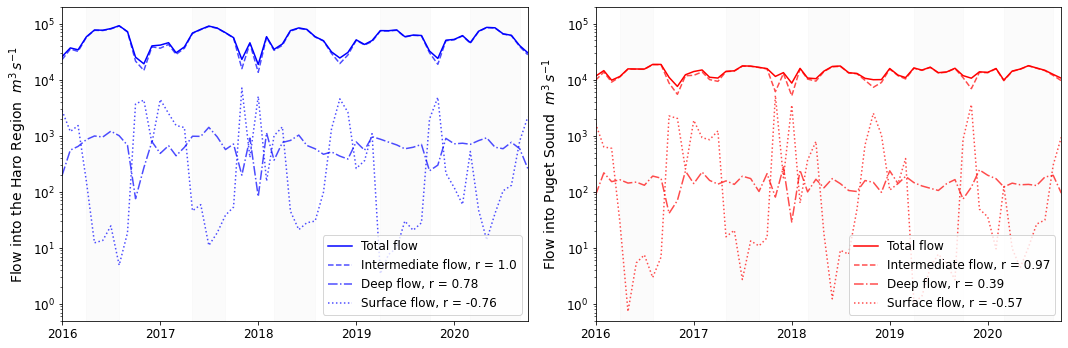

In [15]:
plt.rcParams['font.size'] = 12
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].plot(dates, SoG, 'b', label='Total flow')
ax[0].plot(dates, upSOG, 'b--', alpha = 0.7, label = 'Intermediate flow, r = '+str(np.round(sg_up,2)))
ax[0].plot(dates, cucSOG, 'b', alpha = 0.7, label='Deep flow, r = '+str(np.round(sg_cuc,2)), ls='dashdot')
ax[0].plot(dates, freshSOG, 'b', alpha = 0.7, label='Surface flow, r = '+str(np.round(sg_fresh,2)), ls='dotted')
ax[0].set_yscale('log')
ax[0].set_ylabel('Flow into the Haro Region  $m^3\,s^{-1}$', fontsize=14)
ax[0].set_xticks([dates[i] for i in [0,12,24,36,48]])
ax[0].set_xticklabels([2016,2017,2018,2019,2020],fontsize=12)
ax[0].legend(loc='lower right',fontsize=12)
ax[0].set_ylim([0.5,200000])
ax[0].set_xlim([dates[0],dates[-1]])

ax[1].plot(dates, PS, 'r', label='Total flow')
ax[1].plot(dates, upPS, 'r--', alpha = 0.7, label = 'Intermediate flow, r = '+str(np.round(ps_up,2)))
ax[1].plot(dates, cucPS, 'r', alpha = 0.7, label='Deep flow, r = '+str(np.round(ps_cuc,2)), ls='dashdot')
ax[1].plot(dates, freshPS, 'r', alpha = 0.7, label='Surface flow, r = '+str(np.round(ps_fresh,2)), ls='dotted')
ax[1].set_yscale('log')
ax[1].set_ylabel('Flow into Puget Sound  $m^3\,s^{-1}$', fontsize=14)
ax[1].set_xticks([dates[i] for i in [0,12,24,36,48]])
ax[1].set_xticklabels([2016,2017,2018,2019,2020],fontsize=12)
ax[1].legend(loc='lower right',fontsize=12)
ax[1].set_ylim([0.5,200000])
ax[1].set_xlim([dates[0],dates[-1]])


for i in range(0, len(season),2):
    ax[0].fill_between(dates, 0.5,200000, where=(dates<season[i+1])&(dates>=season[i]), color='whitesmoke', alpha=0.4)
    ax[1].fill_between(dates, 0.5,200000, where=(dates<season[i+1])&(dates>=season[i]), color='whitesmoke', alpha=0.4)
plt.tight_layout()
plt.savefig("./figures/WMflux.png")

# ax[0].fill_between(dates, 0.5,200000, where=(dates<dates[3+1]), color='whitesmoke', alpha=0.4)
# ax[0].fill_between(dates, 0.5,200000, where=(dates<dates[9+1])&(dates>=dates[3]), color='whitesmoke', alpha=0.4)
# ax[0].fill_between(dates, 0.5,200000, where=(dates<dates[21+1])&(dates>=dates[15]), color='whitesmoke', alpha=0.4)
# ax[0].fill_between(dates, 0.5,200000, where=(dates<dates[33+1])&(dates>=dates[27]), color='whitesmoke', alpha=0.4)
# ax[0].fill_between(dates, 0.5,200000, where=(dates<dates[45+1])&(dates>=dates[39]), color='whitesmoke', alpha=0.4)

# ax[1].fill_between(dates, 0.5,200000, where=(dates<dates[9+1])&(dates>=dates[3]), color='whitesmoke', alpha=0.4)
# ax[1].fill_between(dates, 0.5,200000, where=(dates<dates[21+1])&(dates>=dates[15]), color='whitesmoke', alpha=0.4)
# ax[1].fill_between(dates, 0.5,200000, where=(dates<dates[33+1])&(dates>=dates[27]), color='whitesmoke', alpha=0.4)
# ax[1].fill_between(dates, 0.5,200000, where=(dates<dates[45+1])&(dates>=dates[39]), color='whitesmoke', alpha=0.4)